In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-28 15:32:48--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.003s  

2023-04-28 15:32:48 (69.4 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
g = torch.Generator().manual_seed(42)

In [2]:
words = open('names.txt').read().split()

In [3]:
vocab = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(vocab)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
encode = lambda x: [stoi[i] for i in x]
decode = lambda x: ''.join([itos[i] for i in x])

In [8]:
block_size = 3
def build_data(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_data(words[:n1])
Xte, Yte =  build_data(words[n1:n2])
Xdev , Ydev = build_data(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [131]:
class Linear:
    def __init__(self, IN, OUT, bias=True):
        self.weight = torch.randn(IN, OUT, generator=g) / IN ** 0.5 
        self.bias = torch.zeros(OUT) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
            
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.training = True
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_mean
        xnorm = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xnorm + self.beta
        if self.training:
            self.running_mean = self.momentum * self.running_mean +  self.momentum * xmean
            self.running_var = self.momentum * self.running_var +  self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
            
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [132]:
n_emb = 10
n_hidden = 200
vocab_size = len(stoi)


C = torch.randn(vocab_size, n_emb, generator=g, requires_grad=True)
Layers = [Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, vocab_size)]


for layer in Layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 5/3
parameters = [C] + [p for layer in Layers for p in layer.parameters()]
print(f"Total parameters:", sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True 

Total parameters: 134097


In [134]:
steps = 2000
batch_size = 25
ud = []
lr = 0.001
for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) #get minibatch
    Xb , Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in Layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= p.grad * lr
    if i%1000==0:
        print(f". {i}/{steps}   : {loss.item()}")
    with torch.no_grad():
     ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

. 0/2000   : 3.6351728439331055
. 1000/2000   : 2.9923312664031982


layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.50%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.92%
layer 8 (      Tanh): mean +0.00, std 0.63, saturated: 3.18%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.42%


Text(0.5, 1.0, 'activation distribution')

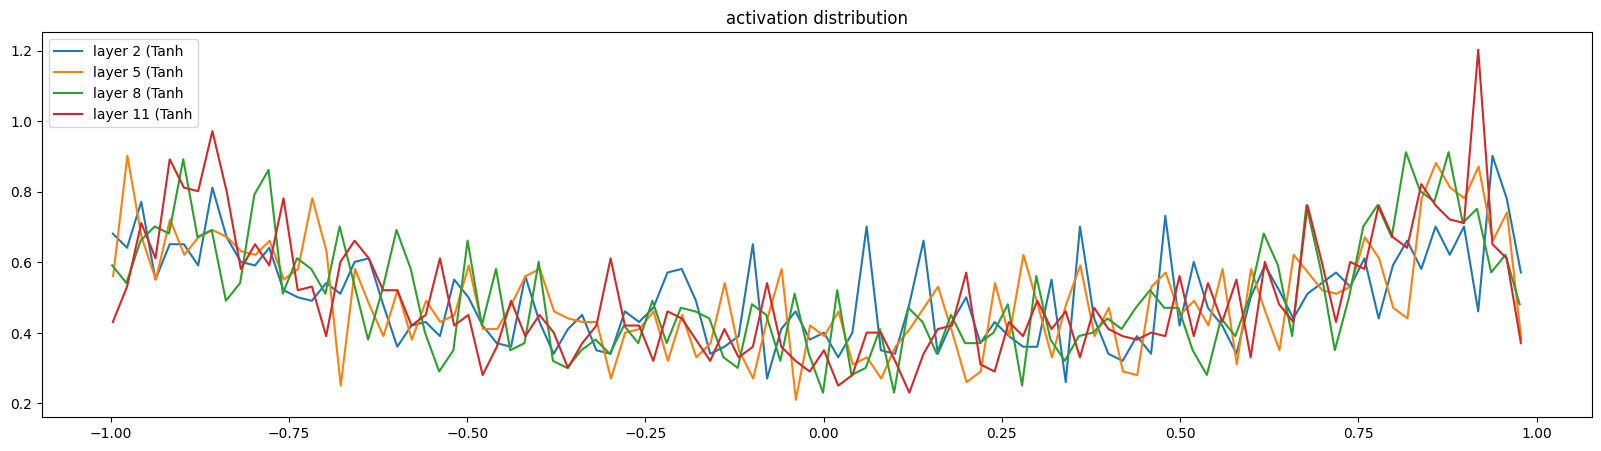

In [127]:
plt.figure(figsize=(20,5))
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 1.329027e-02 | grad:data ratio 1.345282e-02
weight  (30, 200) | mean -0.000012 | std 1.017789e-02 | grad:data ratio 3.424524e-02
weight (200, 200) | mean +0.000051 | std 8.604983e-03 | grad:data ratio 7.303306e-02
weight (200, 200) | mean +0.000010 | std 7.618535e-03 | grad:data ratio 6.462874e-02
weight (200, 200) | mean +0.000015 | std 6.214638e-03 | grad:data ratio 5.255678e-02
weight  (200, 27) | mean +0.000000 | std 2.507953e-02 | grad:data ratio 3.541996e-01


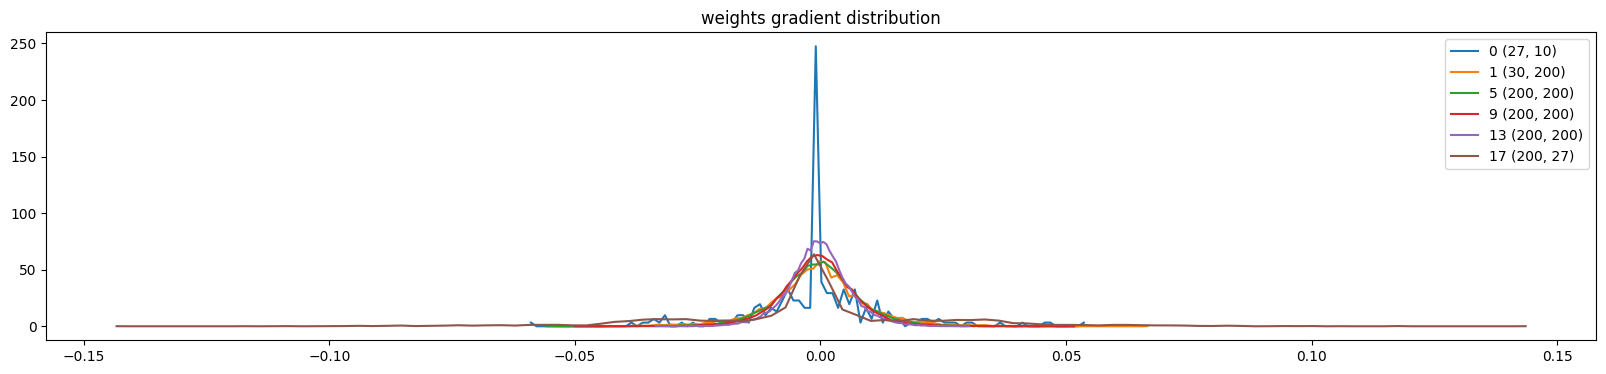

In [138]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [122]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

/tmp/ipykernel_10705/304452877.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [124]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in Layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.864985704421997
val 2.863771438598633


In [ ]:
g = torch.Generator().manual_seed(5)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      

      hpreact = x @ W1 
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
    
  
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      # if we sample the special '.' token, break
      if ix == 0:
        break
      out.append(ix)
    print(''.join(itos[i] for i in out))